<center>
    <h1>Laboratory Experiment #4</h1>
    <h3>Fingerprint Biometrics - Part I: Preprocessing and Feature Extraction</h3>
</center>

#### Email: brian.kramer@ucalgary.ca 30069935, hoang.truong1@ucalgary.ca 30064426, jacob.lansang1@ucalgary.ca 30078981

## Introduction
This purpose of this lab is to practice fingerprint image processing and recognition. We will be practicing fingerprint processing and feature extraction using fingerprint data. This lab covers segmentation, orientation estimation, ridge orientation, and Gabor filters. After this process, our work will be used in the next lab using fingerprint matching algorithms. 

## Importing packages

In [1]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

### Fingerprint Processing Function:

In [2]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

**PART I: Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (3 marks): Select **two fingerprints of different quality (one good and one bad one) from two different fingers each (4 in total)**. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) by adding the **histogram equalization** step. For each fingerprint, perform all the pre-processing, and then add the histogram equalization. Compare the quantity of minutiae and singularities detected WITHOUT and WITH  the histogram equalization step. Record the number of minutiae, the number of singularities for each case. Draw the conclusions from this comparison.

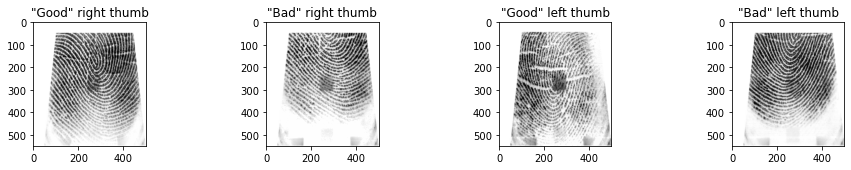

In [3]:
# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1

# img = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))

# right hand prints
img_rh_good = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
img_rh_bad = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/7.bmp', as_gray=True))

#left hand prints
img_lh_good = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/2.bmp', as_gray=True))
img_lh_bad = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/8.bmp', as_gray=True))

# copying the original image in case to use later on
input_img_rh_good = img_rh_good.copy()
input_img_rh_bad = img_rh_bad.copy()
input_img_lh_good = img_lh_good.copy()
input_img_lh_bad = img_lh_bad.copy()

# print(np.min(img_rh_good), np.max(img_rh_good))

#plt.imshow(img_rh_good);

plt.figure(figsize=(16,5))
plt.subplot(2,4,1)
plt.imshow(img_rh_good); plt.title('"Good" right thumb')
plt.subplot(2,4,2)
plt.imshow(img_rh_bad); plt.title('"Bad" right thumb')
plt.subplot(2,4,3)
plt.imshow(img_lh_good); plt.title('"Good" left thumb');
plt.subplot(2,4,4)
plt.imshow(img_lh_bad); plt.title('"Bad" left thumb');

## Matching

##### Loading and processing

In [4]:
# parameters for processing
seg_threshold = 0.4
block_size = 16

# processing
Fp1 = fingerprint_processing(img_rh_good, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img_rh_bad, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img_lh_good, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img_lh_bad, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 47
Total of singularities detected: 4
Total of minutiae detected: 28
Total of singularities detected: 0
Total of minutiae detected: 91
Total of singularities detected: 4
Total of minutiae detected: 48
Total of singularities detected: 2


### Preprocessing

#### Histogram Equalization

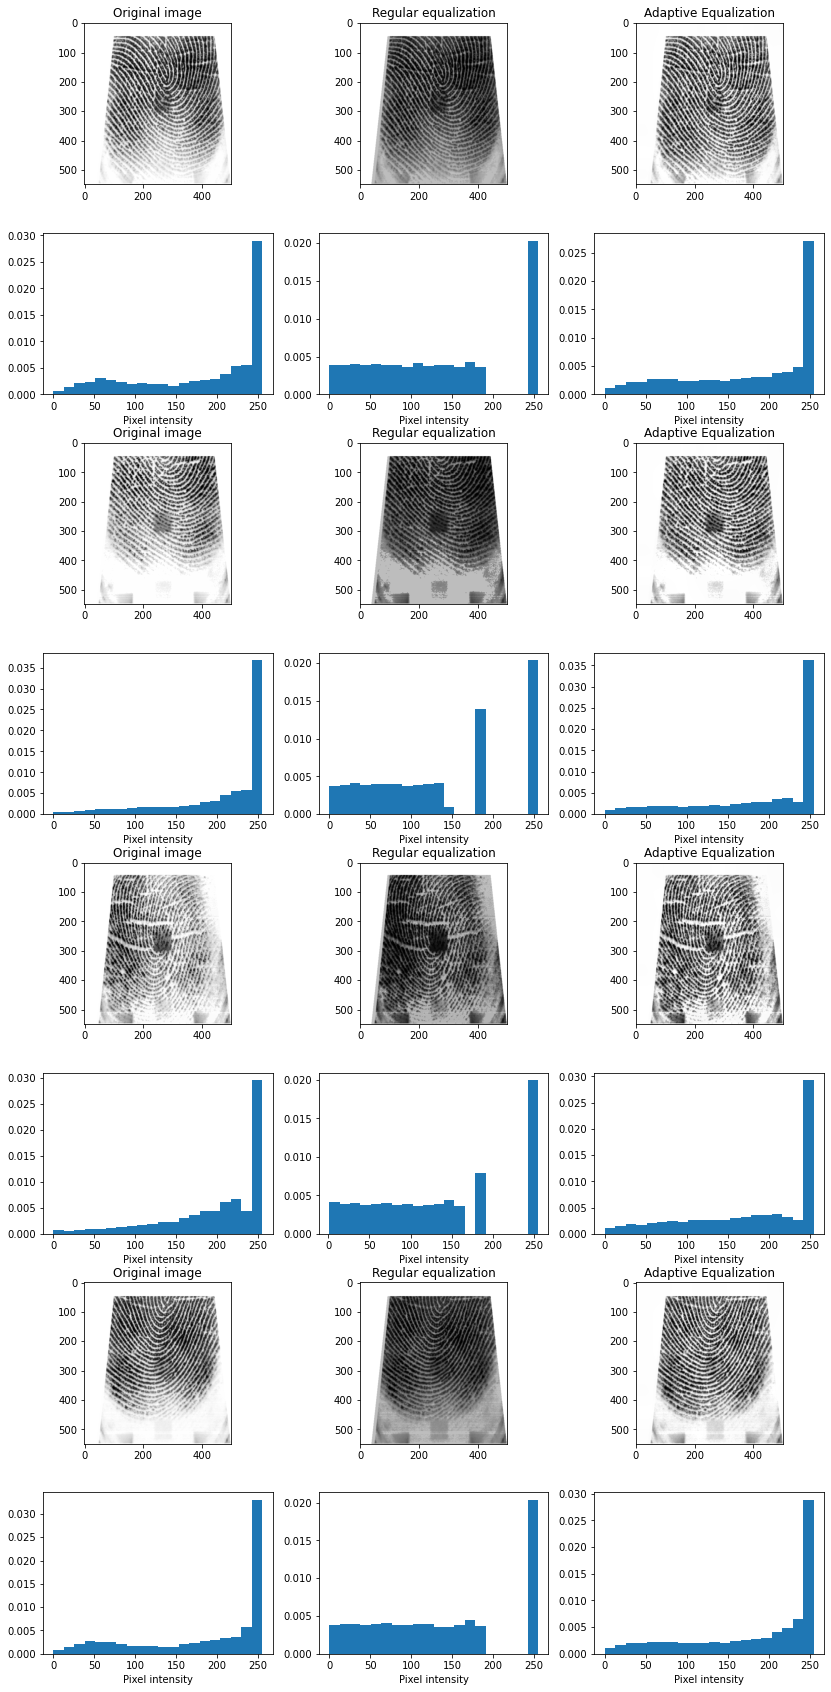

In [5]:
# good right hand prints
img_eq_rh_good1 = img_as_ubyte(equalize_hist(img_rh_good))
img_eq_rh_good2 = img_as_ubyte(equalize_adapthist(img_rh_good))

plt.figure(figsize=(14,30))
plt.subplot(8,3,1)
plt.imshow(img_rh_good); plt.title('Original image')
plt.subplot(8,3,2)
plt.imshow(img_eq_rh_good1); plt.title('Regular equalization')
plt.subplot(8,3,3)
plt.imshow(img_eq_rh_good2); plt.title('Adaptive Equalization');
plt.subplot(8,3,4)
plt.hist(img_rh_good.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(8,3,5)
plt.hist(img_eq_rh_good1.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(8,3,6)
plt.hist(img_eq_rh_good2.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');
plt.subplots_adjust(hspace=.3)

# bad right hand prints
img_eq_rh_bad1 = img_as_ubyte(equalize_hist(img_rh_bad))
img_eq_rh_bad2 = img_as_ubyte(equalize_adapthist(img_rh_bad))

plt.subplot(8,3,7)
plt.imshow(img_rh_bad); plt.title('Original image')
plt.subplot(8,3,8)
plt.imshow(img_eq_rh_bad1); plt.title('Regular equalization')
plt.subplot(8,3,9)
plt.imshow(img_eq_rh_bad2); plt.title('Adaptive Equalization');
plt.subplot(8,3,10)
plt.hist(img_rh_bad.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(8,3,11)
plt.hist(img_eq_rh_bad1.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(8,3,12)
plt.hist(img_eq_rh_bad2.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

# good left hand prints
img_eq_lh_good1 = img_as_ubyte(equalize_hist(img_lh_good))
img_eq_lh_good2 = img_as_ubyte(equalize_adapthist(img_lh_good))

plt.subplot(8,3,13)
plt.imshow(img_lh_good); plt.title('Original image')
plt.subplot(8,3,14)
plt.imshow(img_eq_lh_good1); plt.title('Regular equalization')
plt.subplot(8,3,15)
plt.imshow(img_eq_lh_good2); plt.title('Adaptive Equalization');
plt.subplot(8,3,16)
plt.hist(img_lh_good.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(8,3,17)
plt.hist(img_eq_lh_good1.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(8,3,18)
plt.hist(img_eq_lh_good2.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

# bad left hand prints
img_eq_lh_bad1 = img_as_ubyte(equalize_hist(img_lh_bad))
img_eq_lh_bad2 = img_as_ubyte(equalize_adapthist(img_lh_bad))

plt.subplot(8,3,19)
plt.imshow(img_lh_bad); plt.title('Original image')
plt.subplot(8,3,20)
plt.imshow(img_eq_lh_bad1); plt.title('Regular equalization')
plt.subplot(8,3,21)
plt.imshow(img_eq_lh_bad2); plt.title('Adaptive Equalization');
plt.subplot(8,3,22)
plt.hist(img_lh_bad.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(8,3,23)
plt.hist(img_eq_lh_bad1.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(8,3,24)
plt.hist(img_eq_lh_bad2.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

In [6]:
# parameters for processing
seg_threshold = 0.4
block_size = 16

# processing
Fp1 = fingerprint_processing(img_eq_rh_good2, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img_eq_rh_bad2, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img_eq_lh_good2, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img_eq_lh_bad2, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 52
Total of singularities detected: 4
Total of minutiae detected: 29
Total of singularities detected: 0
Total of minutiae detected: 106
Total of singularities detected: 2
Total of minutiae detected: 63
Total of singularities detected: 2


### Observations
| Thumb print      | Before eq minutiae | After eq minutiae | Before eq singularities | After eq singularities |
|------------------|--------------------|-------------------|-------------------------|------------------------|
| Good right thumb | 47                 | 52                | 4                       | 4                      |
| Bad right thumb  | 28                 | 29                | 0                       | 0                      |
| Good left thumb  | 91                 | 106               | 4                       | 2                      |
| Bad left thumb   | 48                 | 63                | 2                       | 2                      |

As we can see, 

- **Exercise 2** (3 marks): In this Exercise, perform the same steps as in exercise 1, but instead of histogram equalization, choose one **de-noising** method such as *Wiener* or *Median* filter. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) accordingly, record the outcomes and draw the conclusions. 

#### De-noising using Median Filter

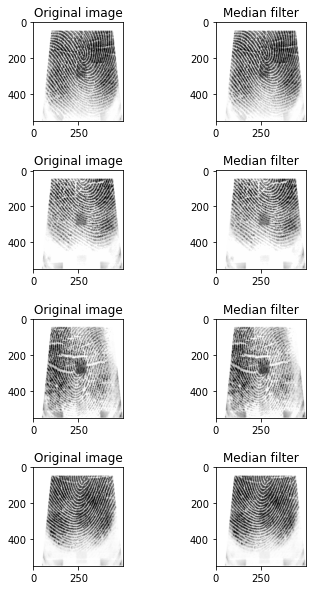

In [7]:
# We have chosen to use the Median Filter

img_median_rh_good = median(img_rh_good)

img_median_rh_bad = median(img_rh_bad)

img_median_lh_good = median(img_lh_good)

img_median_lh_bad = median(img_lh_bad)

plt.figure(figsize=(6,10))

plt.subplot(4,2,1)
plt.imshow(img_rh_good); plt.title('Original image')
plt.subplot(4,2,2)
plt.imshow(img_median_rh_good); plt.title('Median filter');

plt.subplots_adjust(hspace=.5)

plt.subplot(4,2,3)
plt.imshow(img_rh_bad); plt.title('Original image')
plt.subplot(4,2,4)
plt.imshow(img_median_rh_bad); plt.title('Median filter');

plt.subplot(4,2,5)
plt.imshow(img_lh_good); plt.title('Original image')
plt.subplot(4,2,6)
plt.imshow(img_median_lh_good); plt.title('Median filter');

plt.subplot(4,2,7)
plt.imshow(img_lh_bad); plt.title('Original image')
plt.subplot(4,2,8)
plt.imshow(img_median_lh_bad); plt.title('Median filter');


## Matching

##### Loading and processing

In [8]:
# parameters for processing
seg_threshold = 0.4
block_size = 16

# processing
Fp1 = fingerprint_processing(img_median_rh_good, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(img_median_rh_bad, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(img_median_lh_good, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(img_median_lh_bad, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 32
Total of singularities detected: 4
Total of minutiae detected: 21
Total of singularities detected: 0
Total of minutiae detected: 63
Total of singularities detected: 4
Total of minutiae detected: 43
Total of singularities detected: 2


### Observations
| Thumb print      | Before eq minutiae | After eq minutiae | Before eq singularities | After eq singularities |
|------------------|--------------------|-------------------|-------------------------|------------------------|
| Good right thumb | 47                 | 32                | 4                       | 4                      |
| Bad right thumb  | 28                 | 21                | 0                       | 0                      |
| Good left thumb  | 91                 | 63                | 4                       | 4                      |
| Bad left thumb   | 48                 | 43                | 2                       | 2                      |

As we can see, 

- **Exercise 3** (4 marks): In this exercise, perform the same steps as in Exercise 1, but consider the **parameters `block_size` and `threshold`**. Evaluate the impact of these parameters by changing each of them to another value one at a time, for example: **change the `block_size` to 10 (`block_size = 10`) and keep the `threshold = 0.4`** (default). Second, **change the threshold only to `threshold = 0.5` while keeping the `block_size = 16`** (default). Evaluate  the number  of the detected minutiae and singularities. Compare the results and draw the conclusions.  

## Matching

##### Loading and processing

In [9]:
# parameters for processing
seg_threshold = 0.4
block_size = 16

# processing
Fp1 = fingerprint_processing(input_img_rh_good, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(input_img_rh_bad, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(input_img_lh_good, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(input_img_lh_bad, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 47
Total of singularities detected: 4
Total of minutiae detected: 28
Total of singularities detected: 0
Total of minutiae detected: 91
Total of singularities detected: 4
Total of minutiae detected: 48
Total of singularities detected: 2


##### Changing block size and threshold

In [10]:
# parameters for processing
seg_threshold = 0.4
block_size = 10

# processing
Fp1 = fingerprint_processing(input_img_rh_good, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(input_img_rh_bad, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(input_img_lh_good, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(input_img_lh_bad, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 616
Total of singularities detected: 4
Total of minutiae detected: 432
Total of singularities detected: 0
Total of minutiae detected: 423
Total of singularities detected: 4
Total of minutiae detected: 484
Total of singularities detected: 4


In [11]:
# parameters for processing
seg_threshold = 0.5
block_size = 10

# processing
Fp1 = fingerprint_processing(input_img_rh_good, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(input_img_rh_bad, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(input_img_lh_good, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(input_img_lh_bad, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 431
Total of singularities detected: 4
Total of minutiae detected: 314
Total of singularities detected: 0
Total of minutiae detected: 285
Total of singularities detected: 4
Total of minutiae detected: 461
Total of singularities detected: 4


In [12]:
# parameters for processing
seg_threshold = 0.5
block_size = 16

# processing
Fp1 = fingerprint_processing(input_img_rh_good, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(input_img_rh_bad, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(input_img_lh_good, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(input_img_lh_bad, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 40
Total of singularities detected: 4
Total of minutiae detected: 20
Total of singularities detected: 0
Total of minutiae detected: 83
Total of singularities detected: 4
Total of minutiae detected: 45
Total of singularities detected: 2


In [13]:
# parameters for processing
seg_threshold = 0.3
block_size = 16

# processing
Fp1 = fingerprint_processing(input_img_rh_good, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(input_img_rh_bad, block_size=block_size, threshold=seg_threshold)
Fp3 = fingerprint_processing(input_img_lh_good, block_size=block_size, threshold=seg_threshold)
Fp4 = fingerprint_processing(input_img_lh_bad, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 48
Total of singularities detected: 4
Total of minutiae detected: 34
Total of singularities detected: 0
Total of minutiae detected: 131
Total of singularities detected: 4
Total of minutiae detected: 48
Total of singularities detected: 2


### Observations:

## Conclusion:

## Below is example code:

0 255


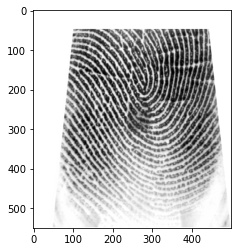

In [14]:
# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
img = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))

# copying the original image in case to use later on
input_img = img.copy()

print(np.min(img), np.max(img))

plt.imshow(img);

### Preprocessing

#### Histogram Equalization

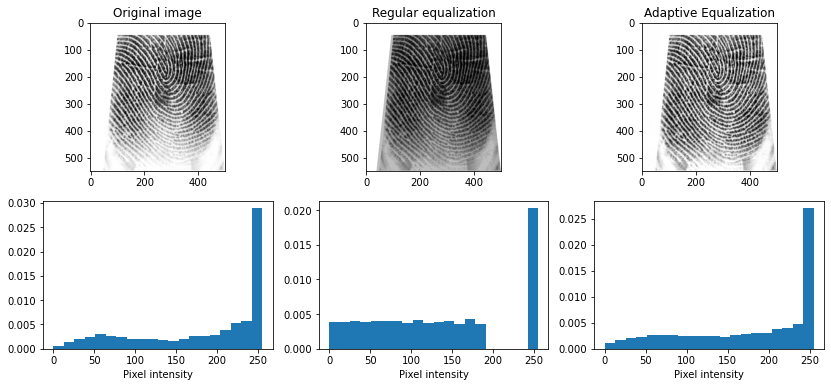

In [15]:
# equalize functions return a float adata 0-1
# to se as uint8 is necessary to convert
img_eq1 = img_as_ubyte(equalize_hist(img))
img_eq2 = img_as_ubyte(equalize_adapthist(img))

plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,3,2)
plt.imshow(img_eq1); plt.title('Regular equalization')
plt.subplot(2,3,3)
plt.imshow(img_eq2); plt.title('Adaptive Equalization');
plt.subplot(2,3,4)
plt.hist(img.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(img_eq1.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(img_eq2.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

#### De-noising

C:\Users\Jacob\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
C:\Users\Jacob\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


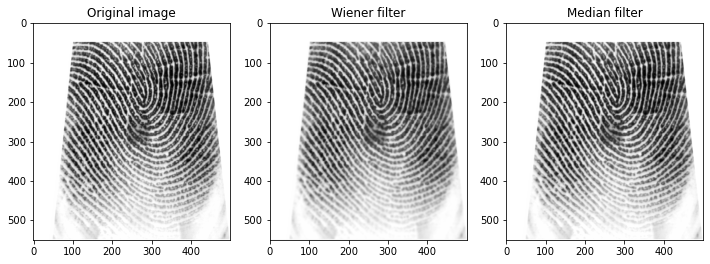

In [16]:
# two different denoising filters are applyed.
# you should chose one

# Wiener filter needs the input image as float (not uint8)
# the (5,5) corresponds to the sized of the window to considered during the processing.
img_wiener = wiener(img.astype('float'), (5,5))
# is necessary to convert the output back to uint8. 
# some additional steps are necessary to have it in 0-255. 
img_wiener = img_as_ubyte((img_wiener-np.min(img_wiener))/(np.max(img_wiener)-np.min(img_wiener)))

# with the Median filter is not necessary to convert back to uint8 
img_median = median(img)

plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(img_wiener); plt.title('Wiener filter')
plt.subplot(1,3,3)
plt.imshow(img_median); plt.title('Median filter');

#### Parameters used for the next steps

In [17]:
# block size usend for windowed processing
block_size = 16

# for segmentation
threshold = 0.2

 ### Normalization

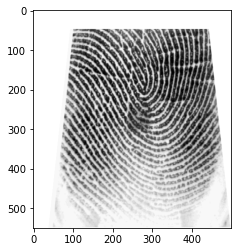

In [18]:
# normalization - removes the effects of sensor noise and finger pressure differences.
normalized_img = normalize(input_img.copy(), float(100), float(100))

plt.imshow(normalized_img);

### Segmentation

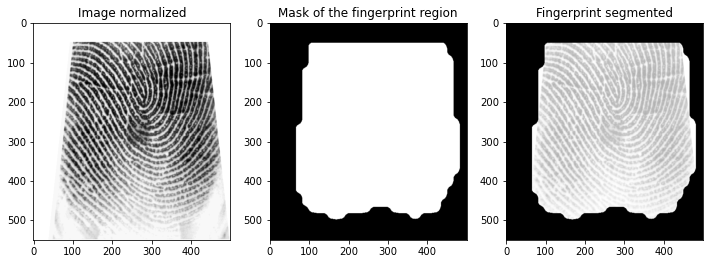

In [19]:
(segmented_img, normim, mask) = segmentation(normalized_img, block_size, threshold)

plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(normim); plt.title('Image normalized')
plt.subplot(1,3,2)
plt.imshow(mask); plt.title('Mask of the fingerprint region')
plt.subplot(1,3,3)
plt.imshow(segmented_img); plt.title('Fingerprint segmented');

Text(0.5, 1.0, 'Fingerprint contour')

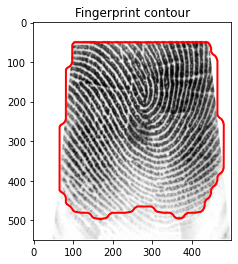

In [20]:
contours = find_contours(mask, 0.8)

plt.imshow(img)
for c in contours:
    plt.plot(c[:, 1], c[:, 0], linewidth=2, c='red')
plt.title('Fingerprint contour')

### Orientation Estimation

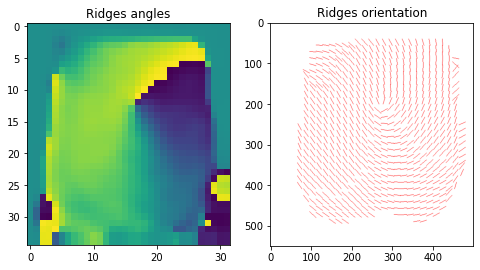

In [21]:
angles = calculate_angles(normalized_img, W=block_size, smooth=True)
orientation_img = visualize_angles(segmented_img, mask, angles, W=block_size)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(angles, cmap='viridis')
plt.title('Ridges angles')
plt.subplot(1,2,2)
plt.imshow(orientation_img)
plt.title('Ridges orientation');

### Ridges Frequency

In [22]:
# find the overall frequency of ridges
freq = ridge_freq(normim, mask, angles, block_size, kernel_size=5, minWaveLength=5, maxWaveLength=15)

### Gabor Filtering

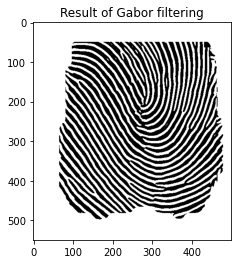

In [23]:
# create gabor filter and do the actual filtering
gabor_img = gabor_filter(normim, angles, freq, block_size2=block_size, kx=0.65, ky=0.65)

plt.imshow(gabor_img, cmap='gray')
plt.title('Result of Gabor filtering');

### Thinning or Skeletonize

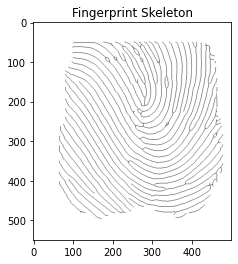

In [24]:
thin_image = skeletonize(gabor_img)

plt.imshow(thin_image, cmap='gray')
plt.title('Fingerprint Skeleton');

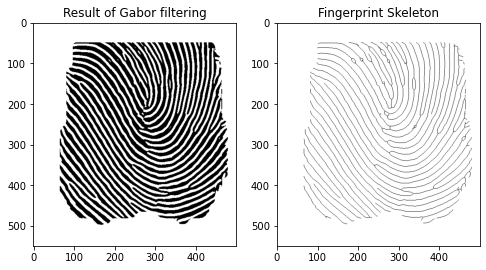

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(gabor_img, cmap='gray')
plt.title('Result of Gabor filtering');
plt.subplot(1,2,2)
plt.imshow(thin_image, cmap='gray')
plt.title('Fingerprint Skeleton');

### Minutiae

Total of minutiae detected: 50


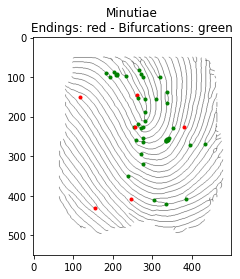

In [26]:
# minutiae_lst is a list with all minutiae coordinates and its type: 
# bifurcation or ending.
# minutiae_img is an image of the minutiae already plot on top of the skeleton
minutiae_lst, minutiae_img, _ = calculate_minutiae(thin_image, mask)

plt.imshow(thin_image)

for p in minutiae_lst:
    x,y = p[0], p[1]
    color = 'red' if p[2] == 'ending' else 'green'
    plt.plot(x,y, color, marker='.')

plt.title('Minutiae\nEndings: red - Bifurcations: green');
print('Total of minutiae detected: %d' % (len(minutiae_lst)))

Total of singularities detected: 4


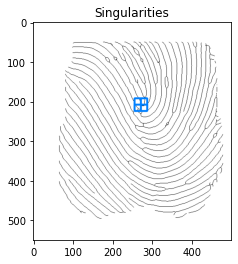

In [27]:
# singularities: whorl, loop and delta.
singularities_lst, singularities_img = calculate_singularities(thin_image, angles, block_size, mask)

plt.imshow(singularities_img)
plt.title('Singularities');
print('Total of singularities detected: %d' % (len(singularities_lst)))

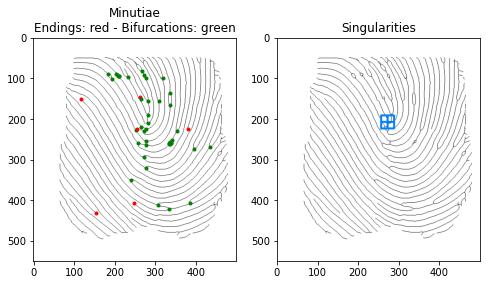

In [28]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(thin_image)
for p in minutiae_lst:
    x,y = p[0], p[1]
    color = 'red' if p[2] == 'ending' else 'green'
    plt.plot(x,y, color, marker='.')
plt.title('Minutiae\nEndings: red - Bifurcations: green');
plt.subplot(1,2,2)
plt.imshow(singularities_img)
plt.title('Singularities');

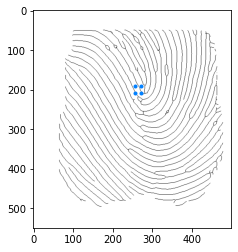

In [29]:
plt.imshow(thin_image)

for p in singularities_lst:
    x,y = p[0], p[1]
    
    # color is defined according to the singularity
    if (p[2] == 'loop'):
        color = 'blue'
    elif (p[2] == 'delta'):
        color = (0, 0.5, 1)
    elif (p[2] == 'whorl'):
        color = (1, 0.6, 1)
        
    plt.plot(x,y, c=color, marker='.')

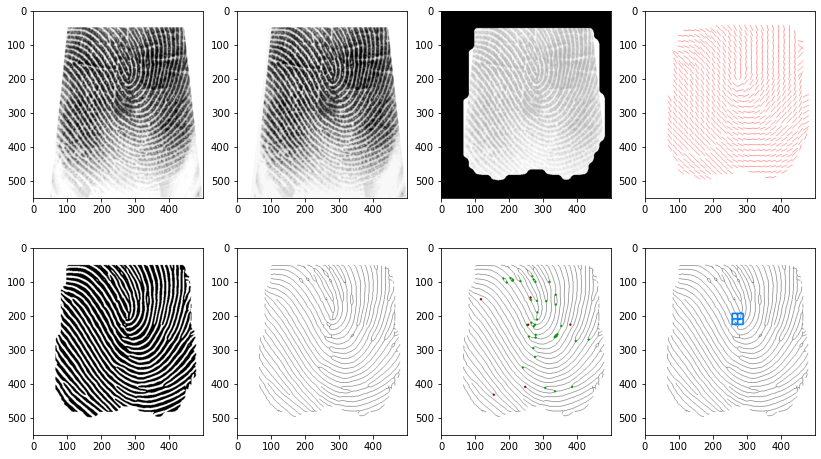

In [30]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_img, cmap='gray');
plt.subplot(2,4,2); plt.imshow(normalized_img, cmap='gray')
plt.subplot(2,4,3); plt.imshow(segmented_img, cmap='gray');
plt.subplot(2,4,4); plt.imshow(orientation_img);
plt.subplot(2,4,5); plt.imshow(gabor_img, cmap='gray');
plt.subplot(2,4,6); plt.imshow(thin_image, cmap='gray');
plt.subplot(2,4,7); plt.imshow(minutiae_img);
plt.subplot(2,4,8); plt.imshow(singularities_img);

### All the steps above compiled in one function

In [31]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

## Matching

##### Loading and processing

In [32]:
# loading two images for Minutiae extraction and matching
im1 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
im2 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/2.bmp', as_gray=True))

# parameters for processing
seg_threshold = 0.4
block_size = 16

# processing
Fp1 = fingerprint_processing(im1, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(im2, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 47
Total of singularities detected: 4
Total of minutiae detected: 84
Total of singularities detected: 4


##### Score based on Minutiae

In [ ]:
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp1, Fp2)
Fp2['imSkeletonAlign'] = imSkeletonAlign
Fp2['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
score = match(Fp1, Fp2, threshold2=match_threshold)
print('score for minutiae: %.4f\n' % (score))

#### Score based on Gabor features

In [ ]:
score2 = MatchGaborFeat(im1, im2)
print('Score using Gabor features: %.4f' % (score2))

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

**PART I: Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (3 marks): Select **two fingerprints of different quality (one good and one bad one) from two different fingers each (4 in total)**. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) by adding the **histogram equalization** step. For each fingerprint, perform all the pre-processing, and then add the histogram equalization. Compare the quantity of minutiae and singularities detected WITHOUT and WITH  the histogram equalization step. Record the number of minutiae, the number of singularities for each case. Draw the conclusions from this comparison.

- **Exercise 2** (3 marks): In this Exercise, perform the same steps as in exercise 1, but instead of histogram equalization, choose one **de-noising** method such as *Wiener* or *Median* filter. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) accordingly, record the outcomes and draw the conclusions. 

- **Exercise 3** (4 marks): In this exercise, perform the same steps as in Exercise 1, but consider the **parameters `block_size` and `threshold`**. Evaluate the impact of these parameters by changing each of them to another value one at a time, for example: **change the `block_size` to 10 (`block_size = 10`) and keep the `threshold = 0.4`** (default). Second, **change the threshold only to `threshold = 0.5` while keeping the `block_size = 16`** (default). Evaluate  the number  of the detected minutiae and singularities. Compare the results and draw the conclusions.  

**PART II: Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (1 mark): Use the demo file `Lab04Fingerprint2gab.ipynb` to perform the Gabor filtering on your fingerprint image, while adjusting the parameters `frequency` and `angle` of the filter. Choose two different values for each of those parameters, one at a time, and visually evaluate the results. What is the impact of  changing the parameters of the Gabor filtering results (visually)? Draw the conclusions.

- **Exercise 2** (3 marks): Use 9 of your fingerprints as a database, or a gallery. Use the remaining one as a  probe. The database of 9 templates (feature vectors) represents the same "individual".

    Develop a simple identification procedure (use loops that repeat 1 to 1 matching several times), to  match  a probed fingerprint of your finger (e.g. left thumb) against 9 different impressions of the same   finger. Use the Jupyter notebook `Lab04Fingerprint1.ipynb` that performs 1 to 1 matching. 
        
    Record the scores (use a table - see the first Lab on Markdown how to do a table in Jupyter notebooks) for the **minutiae based matching**. Note that for this type of matching, the higher the score the better the match.

    Record the number of matches against the same fingers (True Positives - TP), and the number of mismatches against the same fingers (False Negatives - FN). How the choice of the threshold affects the  matching? Use the numbers or graphs to illustrate your answer.

- **Exercise 3** (2 marks): Repeat the same experiment (using the same images) from Exercise 2, but **instead of minutiae based matching, use the method based on the Gabor filter**. Note that the lower the score, the better the match. Again, record the numbers of the True positives and False negatives.
    Compare the results of Gabor score matching with the minutiae based matching. Draw conclusions upon both experiment results.

- **Exercise 4** (4 marks): Use one of your fingerprints (e.g. left thumb) to be used as the  probed one. Use the database with one  impression of the same finger and 10 of some other finger(s). Therefore, you have a database with 11 templates one of which represents the same "individual", and the rest of the templates represent another "individual(s)."
    Develop a ranking identification procedure for minutiae-based matching only. A sample of such procedure is as follows:
    - Record the matching scores for each comparison; use some index corresponding to the fingerprint number. Sort the matching scores: the top score is the maximum score for the Minutia based approach.
    - Do you have a true match?  If your true match is not on top of your ranking, which rank is it?  Use this rank's score as a "thresholding score" that separates a top-ranked group  of the closest matches from the others.
    - Record the number of matches against different fingers as False Positives, and the mismatches as True Negatives. Some False positives may belong to the top ranked group.
    - Draw the conclusions upon your experiment, such as the threshold choice etc.